# Определение возраста покупателей

## Постановка задачи

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:


- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.


Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
import random 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from random import randint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
labels.shape

(7591, 2)

Датасет содержит 7591 изображение - на мой взгляд, это относительно небольшой датаесет для поставленной задачи, что может негативно сказаться на обучении модели и увеличить итоговоую погрешность.

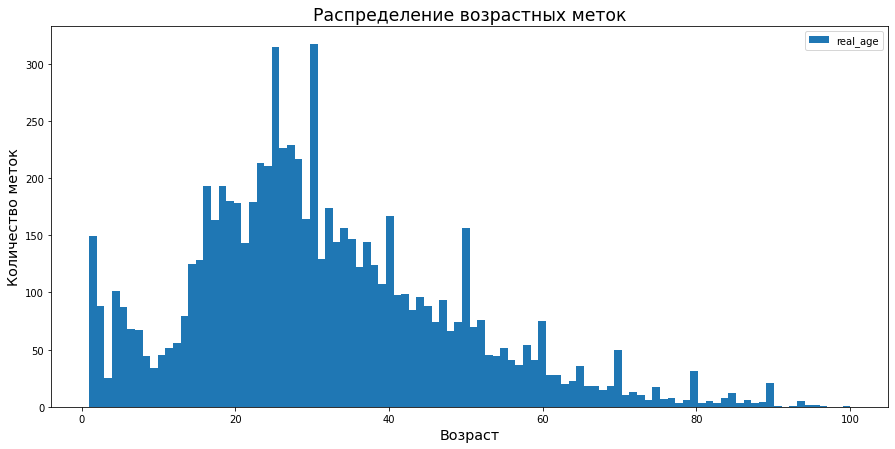

In [4]:
age_plot = labels.plot(kind='hist', bins=100, figsize=(15, 7))
age_plot.set_title('Распределение возрастных меток', fontsize='xx-large')
age_plot.set_xlabel('Возраст', fontsize='x-large')
age_plot.set_ylabel('Количество меток', fontsize='x-large');

Распределение целевых признаков близко к нормальному, однако имеются отдельные выбросы - в 26 лет, и затухающие выбросы каждые 10 лет с 30 до 90 лет.

Отсутствие данных с 0 до года логически объяснимо тем, что покупателей в таком раннем возрасте сложно фиксировать средствами видеофиксации. 

Обращают на себя внимание "провалы" данных в возрасте от 5 до 13-15 лет и в диапазоне от 19 до 23 лет. 

В целом распределение смещено в сторону покупателей в возрасте от 23 до 30 лет. Это необходимо учитывать магазину, т.к. рекомендательные модели, построенные на таких данных, могут неодинаково учитывать интересы других возрастных категорий (возрастная дискриминация). И если для магазина, чьей целевой аудиторией являются молодые и активные, это будет как раз, то для условного магазина у дома в спальном районе, населенном пенсионерами, это может вызвать непонимание потребителей. 

In [5]:
print(labels.describe())

          real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000


In [6]:
features, target = train_gen_flow.next()

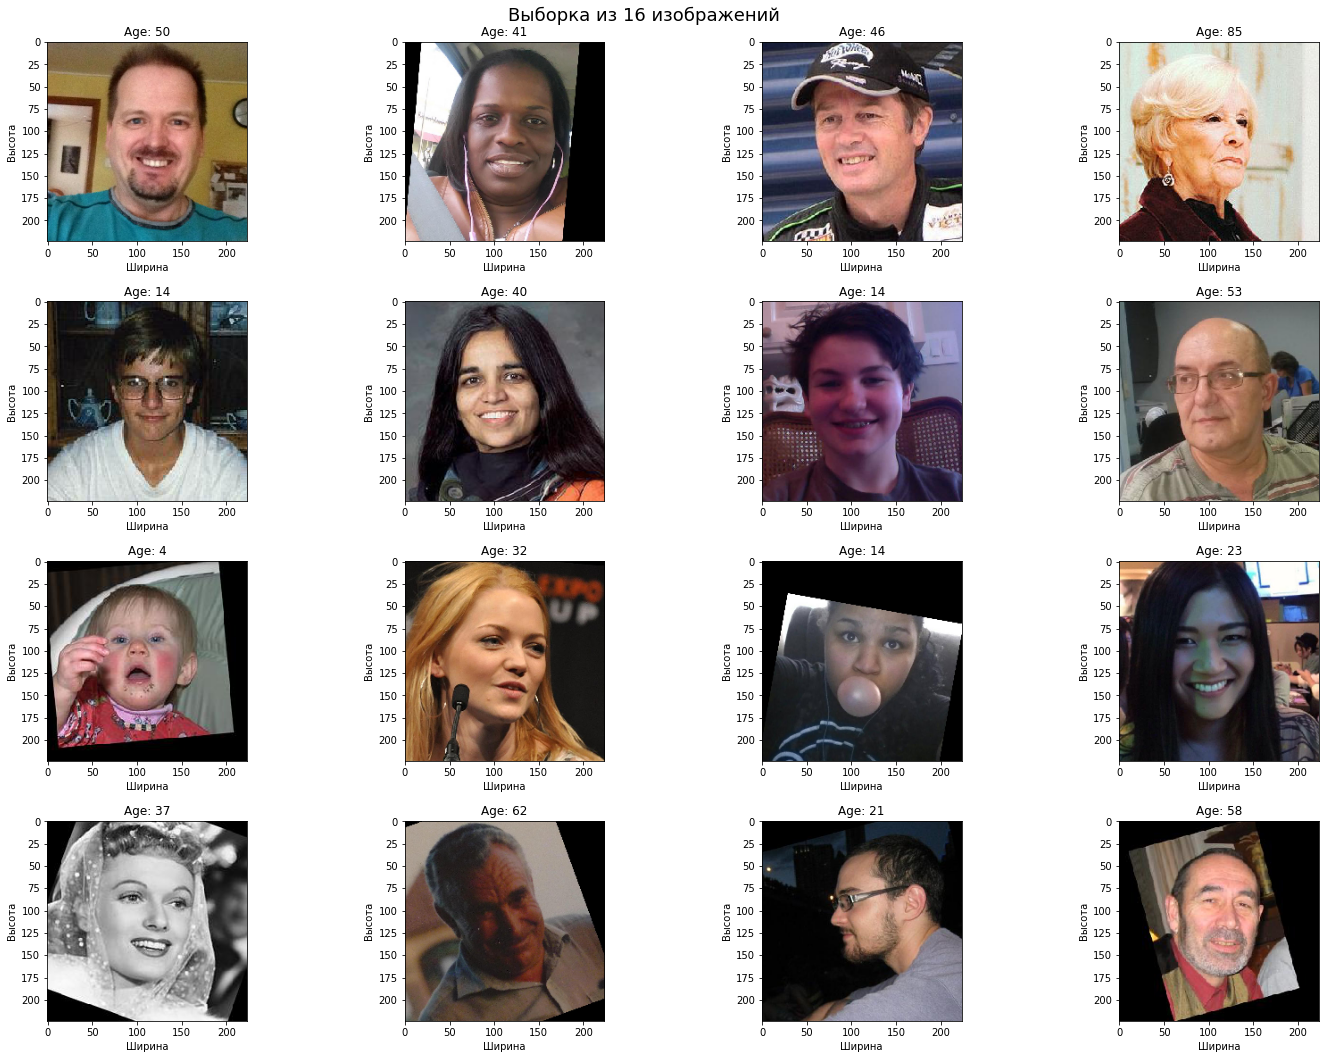

In [7]:
plt.figure(figsize=(22,16)) 
plt.subplots_adjust(hspace=0.3, 
                    wspace=0.3, 
                    top=0.95, 
                    left=0.1,
                    bottom=0.1, 
                    right=0.95,)
plt.suptitle("Выборка из 16 изображений", fontsize=18)
rand_list = random.sample(range(0, 32), 16) 
for i in rand_list:
    j = rand_list.index(i)
    plt.subplot(4,4,j+1, xlabel='Ширина', ylabel='Высота')
    plt.title(f"Age: {target[j]}")
    plt.imshow(features[j])

plt.show()


### Вывод

Датасет содержит 7591 фотографий людей разного возраста.<br>
Основная масса фотографий содержит изображения людей в возрасте примерно от 16 до 60 лет. Также в датасете присутствуют фотографии детей и стариков до 100 лет.<br>

Судя по выведенным выше изображениям, датасет содержит фото людей в головных уборах, очках, с частично закрытым лицом, имеющих различный наклон головы, а также искаженные фото и фото, имеющие различную ориентацию (под различными углами).Также присутствуют черно-белые фотографии и фотографии различного размера.

Все это затруднит обучение модели. 

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd
import os


def load_train(path):
    labels = pd.read_csv(os.path.join(path, 'labels.csv'))
    train_datagen = ImageDataGenerator(rescale=1 / 255.,
                                       horizontal_flip=True,
                                       width_shift_range=0.1,
                                       validation_split=0.25)

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=os.path.join(path, 'final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow


def load_test(path):
    labels = pd.read_csv(os.path.join(path, 'labels.csv'))
    test_datagen = ImageDataGenerator(rescale=1 / 255.,
                                      validation_split=0.25)

    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=os.path.join(path, 'final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    backbone.trainable = True

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model


Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 111s - loss: 251.6848 - mae: 11.2508 - val_loss: 794.1497 - val_mae: 23.2657

Epoch 2/10
178/178 - 87s - loss: 83.3828 - mae: 6.9035 - val_loss: 797.9025 - val_mae: 23.3344

Epoch 3/10
178/178 - 87s - loss: 57.6026 - mae: 5.8126 - val_loss: 347.5650 - val_mae: 13.7020

Epoch 4/10
178/178 - 87s - loss: 41.1039 - mae: 4.8992 - val_loss: 122.6745 - val_mae: 8.5122

Epoch 5/10
178/178 - 87s - loss: 33.3509 - mae: 4.4324 - val_loss: 76.2010 - val_mae: 6.5690

Epoch 6/10
178/178 - 87s - loss: 28.5219 - mae: 4.1071 - val_loss: 89.5949 - val_mae: 7.1212

Epoch 7/10
178/178 - 87s - loss: 23.7159 - mae: 3.7824 - val_loss: 69.9361 - val_mae: 6.2534

Epoch 8/10
178/178 - 87s - loss: 20.8934 - mae: 3.5226 - val_loss: 73.0029 - val_mae: 6.5386

Epoch 9/10
178/178 - 87s - loss: 17.5472 - mae: 3.2421 - val_loss: 66.8802 - val_mae: 6.0352

Epoch 10/10
178/178 - 87s - loss: 15.3477 - mae: 3.0226 - val_loss: 65.5614 - val_mae: 5.9545

60/60 - 9s - loss: 65.5614 - mae: 5.9545

Test MAE: 5.9545

## Анализ обученной модели

Для обучения модели использовалась архитектура ResNet50. Модель была обучена на 10 эпохах с шагом алгоритма оптимизации Adam 0.0001, для оценки функции потерь использовалась метрика MSE. На тестовых данных было получено значение метрики качества МАЕ = 5.9545 лет. Что соответствует требованию - не более 8. 

Также данный результат соответствует первому пункту условий - такая погрешность позволит анализировать покупки и предлагать товары, которые могут заинтересовать покупателей разных возрастных групп.

Однако для второго пункта - Контролировать добросовестность кассиров при продаже алкоголя - погрешность в 

В дальнейшем рекомендуется провести анализ работы модели на разных возрастах, вдруг качество модели сильно отличается в зависимости от возраста.